# ICESat-2 Hackweek 2020: Machine Learning

#### Yara Mohajerani ([ymohajer@uci.edu](mailto:ymohajer@uci.edu))

**Note** Before going through this tutorial, make sure you have the correction environment by running

`conda create --name <env> --file mlenv.lock`
with the `mlenv.lock` file being in this repositoriy, and choose the this environment for your kernel.

---

In this tutorial we will explore the basics of machine learning with an emphasize on neural networks and applications in altimetry. First we will offer a brief introduction to theory and techniques in implementing neural networks, and then will focus on altimetry applications.

## Motivation
Advances in machine learning have made it a valuable tool for extracting insights from large datasets without the need for developing exact analytical algorithms. In particular, this has proven extremely useful for altimetry applications. For example, imagine you have thousands of satellite images and you want to identify paricular features automatically in the dataset. One way is to manually go through the data, which is not practical. The second way is to come up with an analytical algorithm that uses explicit engineered laws to detect the desired features. This is not very easy or robust, to say the least. But machine learning methods can learn to perform the desired task from the data in an approximate manner. Specifically, *supervised* methods use the data along with the desired outputs to accomplish the learning task. Here we will focus on supervised machine learning. An extremely useful subset of supervised machine learning fields is *neural networks*, which will be discussed in this notebook.

Given the shear volume of altimetry data from ICESat-2, the is huge potential in extracting insights from the data with machine learning that were not possible before. Keep in mind that machine learning is a big field and here we focus on only a few specific approaches and a few computational tools. Specifically, we will focus on neural networks largely implemented in `keras`.

---
Introduction to neural networks
---

Neural networks use a series of nonlinear transformations with adjustable (trainable) parameters to approximate an input field into a desired output.

Each 'cell' or unit of a network has an associated weight $w$ and bias $b$, and an activation function $f(z)$ for applying a nonlinear transformation such that the output is

$$
\begin{aligned}
 f(w.x + b)
\end{aligned}
$$

for input $x$.

Some examples of activation functions are 
Sigmoid:

$$
\begin{aligned}
 f(z) = \frac{1}{1+e^{-z}}
\end{aligned}
$$

Rectified Linear Unit (ReLU):

$$
\begin{aligned}
 f(z) = \max(0,z)
\end{aligned}
$$

And many others, which is beyond the scope of this brief tutorial. There are many excellent resources on the choice activation functions (e.g. [Neural Networks and Deep Learning by Michael Nielson](http://neuralnetworksanddeeplearning.com/chap3.html))


A neural network contains many layers of nodes to accomplish more involved transformations. Note that each unit only has one adjustable bias $b$, but each precedening connected note has a weight $w$ associated with it. All the weighted inputs are summed such that the output is

$$
\begin{aligned}
 f(b+\sum_{i} w_ix_i)
\end{aligned}
$$


![Neural network generic example fromw ww.astroml.org](https://www.astroml.org/_images/fig_neural_network_1.png)
<sub>Schematic from [AstroML](https://www.astroml.org/book_figures/chapter9/fig_neural_network.html#book-fig-chapter9-fig-neural-network)
    
    Figure produced by code under BSD license authored by Jake VanderPlas & Brigitta Sipocz.
    The figure produced by this code is published in the textbook "Statistics, Data Mining, and Machine Learning in Astronomy" (2019)
    For more information, see http://astroML.github.com
</sub>

Packages like PyTorch and TensforFlow provide the tools to contruct neural networks in Python. However, here we focus on Keras, a higher-level package which makes it easier to contruct a network.

Here as an example we will contruct a simple model for the quintessential machine learning example of identifying handwritten digits (MNIST dataset).

#### 1) Get data and develop neural network

In [1]:
#--  import required packages
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Activation
from keras.utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#-- Get built-in MNIST data from keras
#-- "Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.""
#-- https://keras.io/datasets/#mnist-database-of-handwritten-digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

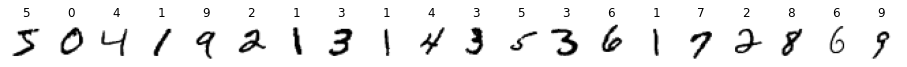

In [3]:
fig, ax = plt.subplots(1, 20, figsize=(16,5))
for i in range(20):
    ax[i].imshow(x_train[i],cmap='binary')
    ax[i].set_title(y_train[i])
    ax[i].axis('off')
plt.show()

In [4]:
#-- Turn the trainign labels (indicating which number each image is), into one-hot encoding
#-- e.g. 3 --> [0,0,0,1,0,0,0,0,0,0]
onehot_train = keras.utils.to_categorical(y_train, num_classes=10)

In [5]:
#-- Make sequential model
model = keras.Sequential()
#-- "Dense implements the operation: output = activation(dot(input, kernel) + bias)"
#-- https://keras.io/layers/core/
#-- first hidden layer has 64 units, and input is 28*28 which is the flattened input data
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1]*x_train.shape[2]))
model.add(Dense(32, activation='relu', input_dim=32))
model.add(Dense(10, activation='softmax'))

This is categorical classification with 10 classes (0-9), hence 10 units in the last layer. We compile the model with a `categorical_crossentropy` loss function used to train the model.

In [6]:
model.compile(optimizer='adam',     # optimization algorithm used (other examples include scholastic gradient descent, etc)
              loss='categorical_crossentropy',
              metrics=['accuracy']) # quantity to be minimized

In [7]:
#-- Train model
#-- We will just use 5 epochs to save time, with batch sizes of 32
#-- batch size is number if data points used in each training iteration
#-- epoch is total number of times the whole dataset is used.
#-- so total number of iterations is total_size/batch_size * epochs
model.fit(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]),
          onehot_train, epochs=5, batch_size=32)

Epoch 1/5
60000/60000 [==============================] - 17s 291us/step - loss: 1.4617 - accuracy: 0.6345
Epoch 2/5
60000/60000 [==============================] - 17s 285us/step - loss: 0.4260 - accuracy: 0.8841
Epoch 3/5
60000/60000 [==============================] - 18s 300us/step - loss: 0.2735 - accuracy: 0.9265
Epoch 4/5
60000/60000 [==============================] - 17s 290us/step - loss: 0.1956 - accuracy: 0.9457
Epoch 5/5
60000/60000 [==============================] - 18s 302us/step - loss: 0.1613 - accuracy: 0.9556


#### 2) Evaluate model

In [8]:
#-- turn testing labels to one-hot encoded
onehot_test = keras.utils.to_categorical(y_test, num_classes=10)
#-- evaluate performance of model
#-- Returns the loss value & metrics value, which in this case is accuracy
model.evaluate(x=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]),
               y=onehot_test, verbose=1)

10000/10000 [==============================] - 1s 149us/step


[0.1948572181949392, 0.953000009059906]

The evaluation output has multiple components. The first is always the loss function, and the remaining elements are the metrics specified in the `compile` command, which in this case is just `accuracy`. We see that even with just 5 epochs we get very good accuracy.

---
# Regression Exercise with Neural Networks with ATL03-like data
---
Before breaking into groups, we will do the set up of the problem together.

The goal is to now do a regerssion problem. You will have to figure out a way to alter the architecture of the neural network to provide an output that is not a set of classifications, but a regression parameter.

First we will create simulated ATL03 data by creating a noisy dataset of a series of patches with linear features and Gaussian noise.

In [9]:
#-- create 2000 line segments in tiles with width 50 and add Guassian noise
n_tiles = 2000
w = 40
pts = 30 # number of poits to sample
repeat = 3 # number of times to repeat the noise addition at each coordinate

# Fixing random state for reproducibility
np.random.seed(13)

#-- training data has dimensions: # of tilesm, # of points, 2 for the x,y coords of points
x = np.empty((n_tiles,pts*repeat,2),dtype=float)
#-- we choose a random slope and intercept in the range -4 to 4 for both, with uniform distribution
y = np.random.uniform(-4,4,(n_tiles,2))

#-- Now populate x with noisy data
#-- to make the data more similar to ATL03, we will have multiple y values for each x value
for i in range(n_tiles):
    #-- create line 
    line = y[i,0] + np.arange(w)*y[i,1] + np.random.normal(loc=0,scale=5,size=w)
    #-- randomly select `pts` number of points
    inds = np.random.randint(0,high=w,size=pts)
    for r in range(repeat):
        x[i,r*pts:(r+1)*pts,0] = inds
        # Add Gaussian noise with standard deviation 10
        x[i,r*pts:(r+1)*pts,1] = line[inds] + np.random.normal(loc=0,scale=10,size=pts)

In [10]:
#-- Separate 10% of elements for testing
#-- randomly extract indices for 10% of elements
ii = np.random.randint(0,high=n_tiles,size=int(n_tiles*0.1))
x_test = x[ii]
y_test = y[ii]
#-- set the rest for training by getting difference between union and intersection
jj = np.setdiff1d(np.union1d(np.arange(n_tiles), ii), np.intersect1d(np.arange(n_tiles), ii))
x_train = x[jj]
y_train = y[jj]
#-- make sure there are no overlapping elements
np.intersect1d(ii,jj)

array([], dtype=int64)

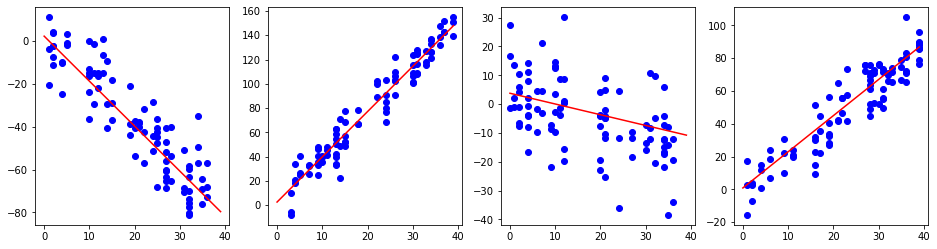

In [11]:
#-- Plot some example tiles
fig,ax = plt.subplots(1, 4,figsize=(16,4))
#-- loop over to plot the first 4 tiles
for i in range(4):
    ax[i].plot(x[i,:,0],x[i,:,1],'bo')
    ax[i].plot(np.arange(w),y[i,0] + np.arange(w)*y[i,1],'r-')
plt.show()

# Breakout (15 minutes)
Try to create a neural network that learn from the examples above and get the slope and coefficient for a given linear feature.



---
### Solution:

In [12]:
model2 = keras.Sequential()

model2.add(Dense(128, activation='relu', input_dim=x.shape[1]*x.shape[2]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
#-- for final model we use a simple linear activation, which simply returns the input unmodified
model2.add(Dense(2, activation='linear'))

#-- we use a mean absolute error as the loss function
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               23168     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 122,498
Trainable params: 122,498
Non-trainable params: 0
_________________________________________________________________


As a side note, in addition to summarizing the model as above, we can also plot it. This is particularly useful as models get larger and more complex with less linear architectures such as skip-connections, parallel layers, etc. that are outside of the scope of this tutorial.

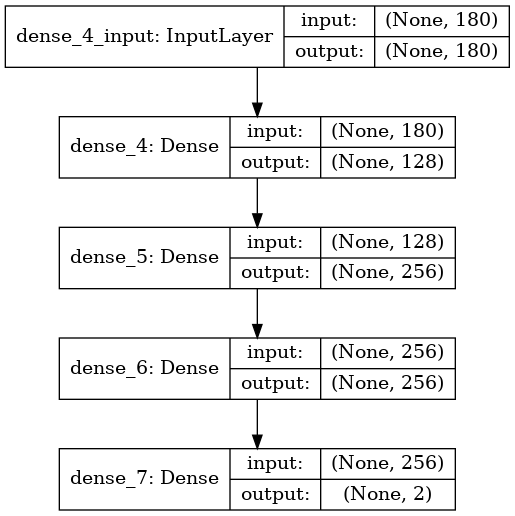

In [13]:
plot_model(model2,show_shapes=True)

In [14]:
#-- Train model
model2.fit(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]),\
          y_train, epochs=40, batch_size=30)

Epoch 1/40
1814/1814 [==============================] - 2s 860us/step - loss: 43.3455 - accuracy: 0.5518
Epoch 2/40
1814/1814 [==============================] - 1s 545us/step - loss: 6.0829 - accuracy: 0.6273
Epoch 3/40
1814/1814 [==============================] - 1s 506us/step - loss: 3.9657 - accuracy: 0.6852
Epoch 4/40
1814/1814 [==============================] - 1s 543us/step - loss: 3.0784 - accuracy: 0.7062
Epoch 5/40
1814/1814 [==============================] - 1s 493us/step - loss: 2.4763 - accuracy: 0.7398
Epoch 6/40
1814/1814 [==============================] - 1s 535us/step - loss: 2.0041 - accuracy: 0.7619
Epoch 7/40
1814/1814 [==============================] - 1s 621us/step - loss: 1.7350 - accuracy: 0.7712
Epoch 8/40
1814/1814 [==============================] - 1s 445us/step - loss: 1.4093 - accuracy: 0.7988
Epoch 9/40
1814/1814 [==============================] - 1s 407us/step - loss: 1.3779 - accuracy: 0.8264
Epoch 10/40
1814/1814 [==============================] - 1s 533

In [15]:
#-- evaluate on test data
model2.evaluate(x=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]), y=y_test, verbose=1)

200/200 [==============================] - 0s 584us/step


[4.342294425964355, 0.7149999737739563]

In [16]:
#-- Also evaluate on train data
model2.evaluate(x=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]), y=y_train, verbose=1)

1814/1814 [==============================] - 0s 176us/step


[0.46593256509948067, 0.9250275492668152]

We see that the network is able to recover the regression coefficients with high accuracy for the train data and reasonable accuracy for the test data.